## What's this
ゲーム理論ベースのprunnnig

## 特徴
剪定を後処理でやらない点と，
各ニューロンが自分の価値を評価する
内生的な構造学習になっている点．
勾配ベースで連続的に構造が決まる．

arxivの論文を参考にしてる
arxivでは三層パーセプトロンだけどこれはCNNに応用したいと思っている

https://www.arxiv.org/abs/2512.22106

### メモ
量子化

In [19]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

分散学習（tf.distribute.MirroredStrategy）は，
論文の競合項が O(N^2) であり replica 間同期コストが支配的となるため，
単一 GPU 構成が推奨される．

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models, mixed_precision
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.constraints import MinMaxNorm
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

In [21]:
# GPUメモリ動的確保（スタベーション対策）
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
# 高速化設定 (Mixed Precision)
mixed_precision.set_global_policy('mixed_float16')
print("Mixed Precision Policy:", mixed_precision.global_policy())

print("TensorFlow Version:", tf.__version__)

Mixed Precision Policy: <DTypePolicy "mixed_float16">
TensorFlow Version: 2.20.0


In [22]:
# 2. FLOPs計算関数 

def calculate_flops(model):
    input_signature = [tf.TensorSpec(shape=(1,) + model.input_shape[1:], dtype=tf.float32)]
    full_model = tf.function(lambda x: model(x))
    concrete_func = full_model.get_concrete_function(input_signature)
    frozen_func, _ = convert_variables_to_constants_v2_as_graph(concrete_func)
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(
        graph=frozen_func.graph,
        run_meta=run_meta, 
        cmd='op', 
        options=opts
    )
    return flops.total_float_ops

In [23]:
# 3. データセット準備 (CPU負荷分散版)
BATCH_SIZE = 16
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 正規化
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# データ拡張関数 (tf.imageを使用)
def augment(image, label):
    image = tf.image.resize(image, [64, 64])  # 64x64
    image = tf.image.random_flip_left_right(image)  # これも入れた方が良い
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

# パイプライン構築
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .shuffle(5000) \
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)

# テストデータもリサイズが必要
def resize_only(image, label):
    image = tf.image.resize(image, [64, 64])
    return image, label

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
    .map(resize_only, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)

/home/niku/github/Neural_Netowrk/.venv/lib/python3.12/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


In [24]:

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# ============================================================
# 1. Participating Conv2D Layer (参加度変数付き畳み込み層)
# ============================================================

class ParticipatingConv2D(layers.Layer):
    """
    ナッシュ均衡pruning用の畳み込み層
    各フィルタに参加度変数 s ∈ [0,1] を持つ
    """
    def __init__(self, filters, kernel_size, strides=1, padding='same', 
                 beta=0.05, gamma=0.05, use_bias=False, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.strides = strides
        self.padding = padding.upper()
        self.use_bias = use_bias
        
        # ペナルティ係数
        self.beta = beta   # L2 正則化
        self.gamma = gamma # L1 正則化 (sparsity)
        
        # L1：不要なニューロンの削除
        # L2：過剰なパラメータの抑制
        
    def build(self, input_shape):
        # 畳み込みカーネル
        self.kernel = self.add_weight(
            name='kernel',
            shape=(*self.kernel_size, input_shape[-1], self.filters),
            initializer='glorot_uniform',
            trainable=True
        )
        
        if self.use_bias:
            self.bias = self.add_weight(
                name='bias',
                shape=(self.filters,),
                initializer='zeros',
                trainable=True
            )
        
        # 参加度変数 (各フィルタに1つ)
        self.participation = self.add_weight(
        name='participation',
        shape=(self.filters,),
        initializer='ones',
        trainable=True,
        constraint=MinMaxNorm(min_value=0.0, max_value=1.0)
        )

        
    def call(self, inputs, training=None):
        # 畳み込み実行
        if self.padding == 'SAME':
            y = tf.nn.conv2d(inputs, self.kernel, strides=self.strides, padding='SAME')
        else:
            y = tf.nn.conv2d(inputs, self.kernel, strides=self.strides, padding='VALID')
        
        if self.use_bias:
            y = tf.nn.bias_add(y, self.bias)
        
        # 参加度を掛ける (各フィルタの出力をスケール)
        y = y * self.participation
        
        # 訓練時のみペナルティを追加
        if training:
            l2_per_filter = tf.reduce_sum(
                tf.square(self.kernel), axis=[0, 1, 2]
            )

            l2_penalty = self.beta * tf.reduce_sum(
                l2_per_filter * tf.square(self.participation)
            )

            l1_penalty = self.gamma * tf.reduce_sum(
                tf.abs(self.participation)
            )

            # ★ ここが重要
            self.add_loss(tf.cast(l2_penalty, tf.float32))
            self.add_loss(tf.cast(l1_penalty, tf.float32))

        
        return y
    
    def get_active_filters(self, threshold=0.01):
        """参加度がthreshold以上のフィルタ数を返す"""
        return tf.reduce_sum(tf.cast(self.participation > threshold, tf.int32)).numpy()
    
    def get_sparsity(self, threshold=0.01):
        """pruningされたフィルタの割合"""
        active = self.get_active_filters(threshold)
        return 1.0 - (active / self.filters)


# ============================================================
# 2. ResNet50V2 with Participating Convolutions
# ============================================================

def bottleneck_block_participating(x, filters, stride=1, beta=0.05, gamma=0.05):
    """
    Participating Conv2D を使った Bottleneck Block
    """
    shortcut = x
    
    # Pre-activation
    pre_act = layers.BatchNormalization()(x)
    pre_act = layers.Activation("relu")(pre_act)
    
    # Shortcut調整
    if stride > 1 or x.shape[-1] != filters * 4:
        # ショートカットは通常のConvでOK
        shortcut = layers.Conv2D(filters * 4, 1, strides=stride, use_bias=False)(pre_act)
    
    # Main path with participating convolutions
    # 1x1 Conv (圧縮)
    m = ParticipatingConv2D(filters, 1, beta=beta, gamma=gamma)(pre_act)
    m = layers.BatchNormalization()(m)
    m = layers.Activation("relu")(m)
    
    # 3x3 Conv (特徴抽出) - ここが重要
    m = layers.ZeroPadding2D(padding=1)(m)
    m = ParticipatingConv2D(filters, 3, strides=stride, padding='valid', 
                           beta=beta, gamma=gamma)(m)
    m = layers.BatchNormalization()(m)
    m = layers.Activation("relu")(m)
    
    # 1x1 Conv (復元)
    m = ParticipatingConv2D(filters * 4, 1, beta=beta, gamma=gamma)(m)
    
    return layers.Add()([shortcut, m])


def build_resnet50_v2_participating(input_shape=(48, 48, 3), classes=10, 
                                   beta=0.05, gamma=0.05):
    """
    Nash equilibrium pruning用のResNet50V2
    """
    inputs = layers.Input(input_shape)
    
    # Stem (最初は通常のConv)
    x = layers.Conv2D(64, 3, strides=1, padding="same", use_bias=False)(inputs)
    
    # Stage 1
    for _ in range(3):
        x = bottleneck_block_participating(x, 64, stride=1, beta=beta, gamma=gamma)
    
    # Stage 2
    x = bottleneck_block_participating(x, 128, stride=2, beta=beta, gamma=gamma)
    for _ in range(3):
        x = bottleneck_block_participating(x, 128, stride=1, beta=beta, gamma=gamma)
    
    # Stage 3
    x = bottleneck_block_participating(x, 256, stride=2, beta=beta, gamma=gamma)
    for _ in range(5):
        x = bottleneck_block_participating(x, 256, stride=1, beta=beta, gamma=gamma)
    
    # Stage 4
    x = bottleneck_block_participating(x, 512, stride=2, beta=beta, gamma=gamma)
    for _ in range(2):
        x = bottleneck_block_participating(x, 512, stride=1, beta=beta, gamma=gamma)
    
    # Head
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(classes, activation="softmax", dtype='float32')(x)
    
    return models.Model(inputs, outputs, name="ResNet50V2_Nash_Pruning")


# ============================================================
# 3. Pruning Statistics Callback
# ============================================================

class PruningStatsCallback(tf.keras.callbacks.Callback):
    """
    各エポック後に参加度統計を記録するコールバック
    """
    def __init__(self, threshold=0.01):
        super().__init__()
        self.threshold = threshold
        self.history = {
            'active_filters': [],
            'sparsity': [],
            'mean_participation': []
        }
    
    def on_epoch_end(self, epoch, logs=None):
        total_filters = 0
        active_filters = 0
        participation_sum = 0.0
        
        for layer in self.model.layers:
            if isinstance(layer, ParticipatingConv2D):
                total_filters += layer.filters
                active_filters += layer.get_active_filters(self.threshold)
                participation_sum += tf.reduce_sum(layer.participation).numpy()
        
        sparsity = 1.0 - (active_filters / total_filters) if total_filters > 0 else 0.0
        mean_participation = participation_sum / total_filters if total_filters > 0 else 0.0
        
        self.history['active_filters'].append(active_filters)
        self.history['sparsity'].append(sparsity)
        self.history['mean_participation'].append(mean_participation)
        
        print(f"\n[Pruning Stats] Active: {active_filters}/{total_filters} "
              f"({(1-sparsity)*100:.1f}%), Mean s: {mean_participation:.4f}")


# ============================================================
# 4. 使用例
# ============================================================

if __name__ == "__main__":
    # モデル構築
    model = build_resnet50_v2_participating(
        input_shape=(48, 48, 3),
        classes=10,
        beta=0.05,   # L2ペナルティ (大きいほどpruning強)
        gamma=0.05   # L1ペナルティ (大きいほどsparsity強)
    )
    
    model.summary()
    
    # コンパイル (add_lossが自動で使われる)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # コールバック
    pruning_stats = PruningStatsCallback(threshold=0.01)
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )
    
    print("\nモデル準備完了!")
    print("データセットを用意して model.fit() で訓練開始してください")
    print(f"beta={0.05}, gamma={0.05} で設定済み")
    print("値を大きくするとより強くpruningされます")

Model: "ResNet50V2_Nash_Pruning"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 48, 48,    │      1,728 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_196      │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ participating_conv… │ (None, 48, 48,    │      4,160 │ activation_196[0… │
│ (ParticipatingConv… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ participating_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_197      │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_64   │ (None, 50, 50,    │          0 │ activation_197[0… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ participating_conv… │ (None, 48, 48,    │     36,928 │ zero_padding2d_6… │
│ (ParticipatingConv… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ participating_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_198      │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 48, 48,    │     16,384 │ activation_196[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ participating_conv… │ (None, 48, 48,    │     16,640 │ activation_198[0… │
│ (ParticipatingConv… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_64 (Add)        │ (None, 48, 48,    │          0 │ conv2d_21[0][0],  │
│                     │ 256)              │            │ participating_co… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │      1,024 │ add_64[0][0]      │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_199      │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ participating_conv… │ (None, 48, 48,    │     16,448 │ activation_199[0

 Total params: 23,581,258 (89.96 MB)

 Trainable params: 23,535,818 (89.78 MB)

 Non-trainable params: 45,440 (177.50 KB)


モデル準備完了!
データセットを用意して model.fit() で訓練開始してください
beta=0.05, gamma=0.05 で設定済み
値を大きくするとより強くpruningされます


In [25]:
# 5. モデル構築とFLOPs測定
model = build_resnet50_v2_participating(
    input_shape=(64, 64, 3),
    classes=10,
    beta=1e-7,
    gamma=1e-7
)


print("\n" + "="*40)
print("【Baseline (Normal) モデル計算量】")
print("="*40)
try:
    flops_val = calculate_flops(model)
    params = model.count_params()
    print(f"パラメータ数: {params:,}")
    print(f"FLOPs: {flops_val / 10**9:.4f} G (ギガ)")
except Exception as e:
    print(f"FLOPs計算エラー: {e}")
print("="*40 + "\n")


【Baseline (Normal) モデル計算量】


/home/niku/github/Neural_Netowrk/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_940
Received: inputs=['Tensor(shape=(1, 64, 64, 3))']
  warnings.warn(msg)
I0000 00:00:1767615305.649571     819 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1767615305.655630     819 single_machine.cc:376] Starting new session
I0000 00:00:1767615305.670213     819 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



=========================Options=============================
パラメータ数: 23,581,258
FLOPs: 10.4250 G (ギガ)

-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. N

`EarlyStopping`が効いていなかった
（`patience` が大きすぎ + `min_delta=0` → `val_loss` の微小揺れで止まらない）
→ `pruning` の挙動は十分見えたので条件を詰めて再実行する


結論から言うと、揺れ動きすぎて`EarlyStopping`効いてないので、ログを見るとだいたいEpoch20で収束してるっぽいのでそこで学習を終わらせる

In [26]:
# --- コンパイル ---
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# コールバック
pruning_stats = PruningStatsCallback(threshold=0.01)
    
# 1. Early Stopping
# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     patience=10,
#     min_delta=1e-3,
#     restore_best_weights=True,
#     verbose=1
# )


# 2. LR Decay
lr_decay = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,         # 停滞したら学習率を半分にする
    patience=5,         # 5回様子を見てダメなら下げる
    min_lr=1e-6,
    verbose=1
)

# 3. fitに渡す
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,         # Pruningには時間がかかるので多めに
    # callbacks=[early_stop, lr_decay, pruning_stats] # lr_decay
    callbacks=[lr_decay, pruning_stats] # lr_decay
)

Epoch 1/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3353 - loss: 1.8102
[Pruning Stats] Active: 14083/22656 (62.2%), Mean s: 0.0281
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 425s 84ms/step - accuracy: 0.4079 - loss: 1.6077 - val_accuracy: 0.4164 - val_loss: 1.7938 - learning_rate: 0.0010
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5498 - loss: 1.2497
[Pruning Stats] Active: 13833/22656 (61.1%), Mean s: 0.0264
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 258s 83ms/step - accuracy: 0.5740 - loss: 1.1858 - val_accuracy: 0.5458 - val_loss: 1.4226 - learning_rate: 0.0010
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6359 - loss: 1.0295
[Pruning Stats] Active: 13534/22656 (59.7%), Mean s: 0.0251
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 255s 82ms/step - accuracy: 0.6494 - loss: 0.9906 - val_accuracy: 0.6589 - val_loss: 0.9921 - learning_rate: 0.0010
Epoch 4/20
3117/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6860 - loss: 0.8907
[Pruning Stats] Active: 13

In [27]:
# 7. 結果の可視化（個別保存版）
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

print(f"\n{'='*50}")
print(f"学習終了: 全{len(acc)}エポック (0-{len(acc)-1})")
print(f"最終 Val Accuracy: {val_acc[-1]:.4f}")
print(f"最終 Val Loss: {val_loss[-1]:.4f}")
print(f"{'='*50}\n")


学習終了: 全20エポック (0-19)
最終 Val Accuracy: 0.8372
最終 Val Loss: 0.6332



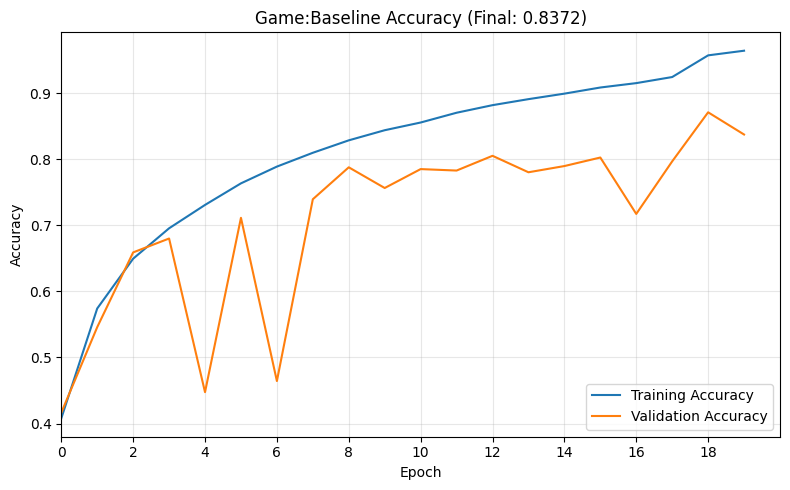

In [28]:
# Accuracyグラフ
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Game:Baseline Accuracy (Final: {val_acc[-1]:.4f})')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim(0, len(acc))
plt.xticks(range(0, len(acc), 2))
plt.tight_layout()
plt.savefig('baseline_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()


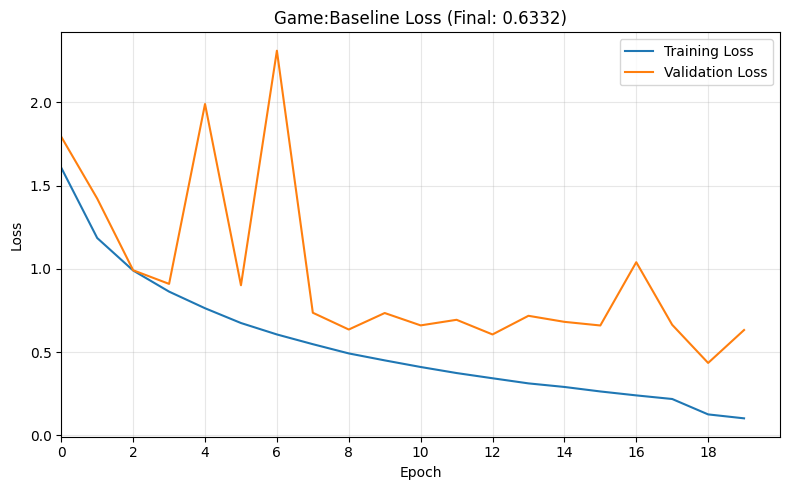

In [29]:
# Lossグラフ
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Game:Baseline Loss (Final: {val_loss[-1]:.4f})')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(0, len(acc))
plt.xticks(range(0, len(acc), 2))
plt.tight_layout()
plt.savefig('baseline_loss.png', dpi=150, bbox_inches='tight')
plt.show()

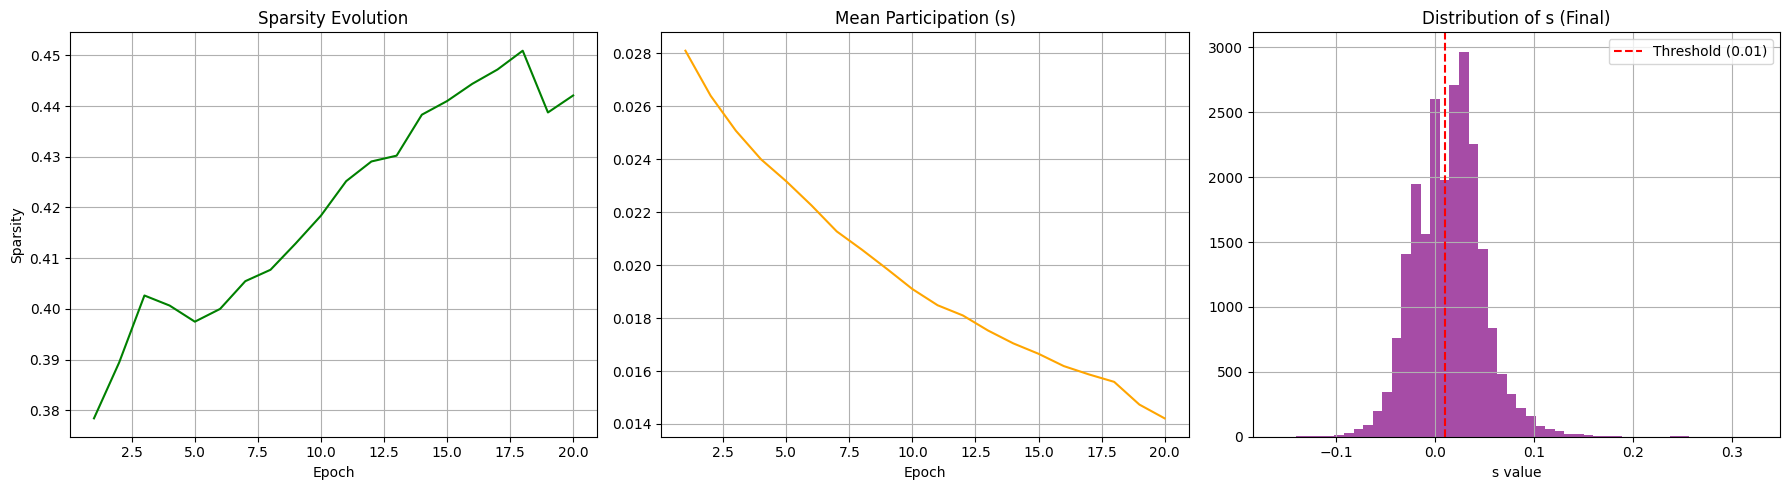

In [ ]:
sparsity_history = pruning_stats.history['sparsity']
mean_s_history = pruning_stats.history['mean_participation']
epochs = range(1, len(sparsity_history) + 1)

# 最終的な s の分布を取得
final_s_values = []
for layer in model.layers:
    if hasattr(layer, 'participation'):
        final_s_values.extend(layer.participation.numpy())

plt.figure(figsize=(18, 5))

# 1. Sparsityの推移 (徐々に上がっているか？)
plt.subplot(1, 3, 1)
plt.plot(epochs, sparsity_history, label='Sparsity', color='green')
plt.title('Sparsity Evolution')
plt.xlabel('Epoch')
plt.ylabel('Sparsity')
plt.grid(True)

# 2. 参加度 s の平均推移 (徐々に下がっているか？)
plt.subplot(1, 3, 2)
plt.plot(epochs, mean_s_history, label='Mean s', color='orange')
plt.title('Mean Participation (s)')
plt.xlabel('Epoch')
plt.grid(True)

# 3. s のヒストグラム (0付近にゾンビが溜まっていないか？)
plt.subplot(1, 3, 3)
plt.hist(final_s_values, bins=50, color='purple', alpha=0.7)
plt.axvline(x=0.01, color='red', linestyle='--', label='Threshold (0.01)')
plt.title('Distribution of s (Final)')
plt.xlabel('s value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [31]:
# 保存（後の比較用）
model.save("resnet50v2_baseline.h5")
print("\n保存完了:")
print("  - baseline_accuracy.png")
print("  - baseline_loss.png")
print("  - resnet50v2_baseline.h5")


保存完了:
  - baseline_accuracy.png
  - baseline_loss.png
  - resnet50v2_baseline.h5
